In [1]:
"""https://www.science.org/doi/10.1126/science.1199295"""

import http.cookiejar
import io
import pathlib
import re
import shutil
import subprocess
import urllib.parse
import urllib.request
import zipfile

DOI = '10.1126/science.1199295'

PDF = pathlib.Path('1199295-atkinson-som.pdf')

TXT = PDF.with_suffix('.txt')

URL = 'https://www.science.org/action/downloadSupplement'

URL = (urllib.parse.urlparse(URL)
       ._replace(query=urllib.parse.urlencode({'doi': DOI,
                                               'file': PDF})))

USER_AGENT = ('Mozilla/5.0 (X11; U; Linux i686)'
              ' Gecko/20071127 Firefox/2.0.0.11')


if not PDF.exists():
    cookies = http.cookiejar.CookieJar()
    processor = urllib.request.HTTPCookieProcessor(cookies)
    opener = urllib.request.build_opener(processor)

    request = urllib.request.Request(URL.geturl(),
                                     headers={'User-Agent': USER_AGENT})
    with opener.open(request) as u, PDF.open('wb') as f:
        shutil.copyfileobj(u, f)

if not TXT.exists():  # requires one of popper-utils, miktex-poppler-bin, xpdf
    cmd = ['pdftotext', '-f', '21', '-l', '33', '-layout', '-nopgbrk', PDF, TXT]
    subprocess.run(cmd, check=True)

_, _, S1 = TXT.read_text(encoding='utf-8').strip().partition('\n\n\n')

assert ',' not in S1

len(S1)

78729

In [2]:
S1_HEAD = ['Language Name',
           'WALS code',
           'Family',
           'Latitude',
           'Longitude',
           'Normalized Vowel Diversity',
           'Normalized Consonant Diversity',
           'Normalized Tone Diversity',
           'Total Normalized Phoneme Diversity',
           'ISO codes',
           'Estimated Speaker Pop. Size',
           'Distance from best fit origin']

S1_FEAT = [h for h in S1_HEAD if h.startswith('Normalized ')]
S1_OUTC = S1_HEAD[-2:]

S1_DATA = S1[S1.index('\nAbkhaz '):].strip()

S1_DATA = re.sub(r'(\))([a-z]{3} )', r'\1 \2', S1_DATA)  # fix missing space
S1_DATA = re.sub(r'\n +([a-z]{3})\n(.+?)  ', r'\n\2 \1 ', S1_DATA)  # fix splitted lines
S1_DATA = S1_DATA.replace('(San Mateo del Mar)', '(San Mateo Del Mar)')  # simplify iso detection

S1_DATA = [l.strip() for l in S1_DATA.splitlines()]


len(S1_HEAD), len(S1_DATA)

(12, 504)

In [3]:
ROW = re.compile(r'''^
(.+?)\ +
([a-z]{2,3})\ +
(.+?)\ +
(-?\d+(?:\.\d+)?)\ +
(-?\d+(?:\.\d+)?)\ +
(-?\d+\.\d+)\ +
(-?\d+\.\d+)\ +
(-?\d+\.\d+)\ +
(-?\d+\.\d+)\ +
(.+?)\ +
(\d+)\ +
(\d+(?:\.\d+)?)
$''', flags=re.VERBOSE)


csv = '\n'.join(','.join(r) for r in [S1_HEAD] + [ROW.match(l).groups() for l in S1_DATA])

csv[:500]

'Language Name,WALS code,Family,Latitude,Longitude,Normalized Vowel Diversity,Normalized Consonant Diversity,Normalized Tone Diversity,Total Normalized Phoneme Diversity,ISO codes,Estimated Speaker Pop. Size,Distance from best fit origin\nAbkhaz,abk,Northwest Caucasian,43.08,41,-1.2345266,-1.5544112,-0.7687792,-1.185905651,abk,105952,5856.362\nAcoma,aco,Keresan,34.92,-107.58,-0.4846364,-0.7169629,1.86204304,0.220147906,kjq,3391,18601.19\nAndoke,adk,Andoke,-0.67,-72,1.3900889,-1.5544112,0.54663194,0.'

In [4]:
%matplotlib inline

import itertools

import numpy as np
import pandas as pd
import scipy.stats


def pearsonr(df, left, right, func=scipy.stats.pearsonr):
    df = df[[left, right]].dropna()
    name = '%s & %s' % (left, right)
    return pd.Series(func(df[left], df[right]), index=('r', 'p'), name=name)


with io.StringIO(csv) as f:
    s1 = pd.read_csv(f, na_values='', keep_default_na=False, index_col='WALS code')

s1.info()
assert s1.index.is_unique
assert s1.index.is_monotonic_increasing
s1.head()

<class 'pandas.core.frame.DataFrame'>
Index: 504 entries, abk to zun
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Language Name                       504 non-null    object 
 1   Family                              504 non-null    object 
 2   Latitude                            504 non-null    float64
 3   Longitude                           504 non-null    float64
 4   Normalized Vowel Diversity          504 non-null    float64
 5   Normalized Consonant Diversity      504 non-null    float64
 6   Normalized Tone Diversity           504 non-null    float64
 7   Total Normalized Phoneme Diversity  504 non-null    float64
 8   ISO codes                           504 non-null    object 
 9   Estimated Speaker Pop. Size         504 non-null    int64  
 10  Distance from best fit origin       504 non-null    float64
dtypes: float64(7), int64(1), object(3)
memory usage:

,Language Name,Family,Latitude,Longitude,Normalized Vowel Diversity,Normalized Consonant Diversity,Normalized Tone Diversity,Total Normalized Phoneme Diversity,ISO codes,Estimated Speaker Pop. Size,Distance from best fit origin
WALS code,,,,,,,,,,,
abk,Abkhaz,Northwest Caucasian,43.08,41.00,-1.234527,-1.554411,-0.768779,-1.185906,abk,105952,5856.362
aco,Acoma,Keresan,34.92,-107.58,-0.484636,-0.716963,1.862043,0.220148,kjq,3391,18601.190
adk,Andoke,Andoke,-0.67,-72.00,1.390089,-1.554411,0.546632,0.127437,ano,619,23780.160
aea,Aleut (Eastern),Eskimo-Aleut,54.75,-164.00,-1.234527,0.957934,-0.768779,-0.348457,ale,490,14629.420
aeg,Arabic (Egyptian),Afro-Asiatic,30.00,31.00,-0.484636,0.120485,-0.768779,-0.377643,arz,46321000,4153.443


In [5]:
PAIRS = list(itertools.product(S1_OUTC, S1_FEAT + ['Total Normalized Phoneme Diversity']))


pd.DataFrame([pearsonr(s1, x, y) for x, y in PAIRS]).round(3)

,r,p
Estimated Speaker Pop. Size & Normalized Vowel Diversity,0.032,0.480
Estimated Speaker Pop. Size & Normalized Consonant Diversity,0.090,0.044
Estimated Speaker Pop. Size & Normalized Tone Diversity,0.037,0.413
Estimated Speaker Pop. Size & Total Normalized Phoneme Diversity,0.082,0.065
Distance from best fit origin & Normalized Vowel Diversity,-0.394,0.000
Distance from best fit origin & Normalized Consonant Diversity,-0.260,0.000
Distance from best fit origin & Normalized Tone Diversity,-0.391,0.000
Distance from best fit origin & Total Normalized Phoneme Diversity,-0.545,0.000


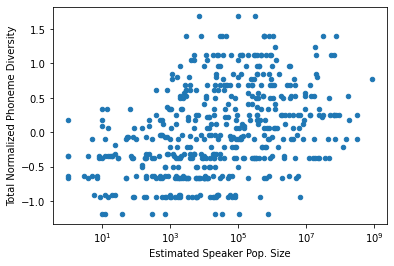

In [6]:
s1.plot.scatter(x='Estimated Speaker Pop. Size', y='Total Normalized Phoneme Diversity', logx=True);

In [7]:
(pearsonr(s1.assign(Population=s1['Estimated Speaker Pop. Size'].apply(np.log10)),
         'Population', 'Total Normalized Phoneme Diversity')
 .to_frame().T.round(3))

,r,p
Population & Total Normalized Phoneme Diversity,0.385,0.0


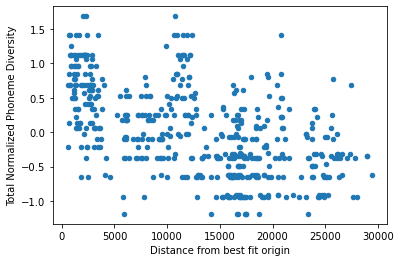

In [8]:
s1.plot.scatter(x='Distance from best fit origin', y='Total Normalized Phoneme Diversity');

In [9]:
URL = 'http://cdstar.shh.mpg.de/bitstreams/EAEA0-7269-77E5-3E10-0/wals_language.csv.zip'

ARCHIVE = pathlib.Path(URL.rpartition('/')[2])

EXTRACT = 'language.csv'

INFO = ['wals_code', 'Name', 'family', 'latitude', 'longitude']

FEAT = ['2A Vowel Quality Inventories', '1A Consonant Inventories', '13A Tone']


if not ARCHIVE.exists():
    urllib.request.urlretrieve(URL, ARCHIVE)

with zipfile.ZipFile(ARCHIVE) as archive:
    wf = pd.read_csv(archive.open(EXTRACT), encoding='utf-8',
                     na_values='', keep_default_na=False,
                     index_col=INFO[0], usecols=INFO + FEAT)

wf.info()
assert wf.index.is_unique

<class 'pandas.core.frame.DataFrame'>
Index: 2679 entries, aab to zzo
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          2679 non-null   object 
 1   latitude                      2679 non-null   float64
 2   longitude                     2679 non-null   float64
 3   family                        2679 non-null   object 
 4   1A Consonant Inventories      563 non-null    object 
 5   2A Vowel Quality Inventories  564 non-null    object 
 6   13A Tone                      527 non-null    object 
dtypes: float64(2), object(5)
memory usage: 167.4+ KB


In [10]:
wf = wf.dropna(how='all', subset=FEAT)

wf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 567 entries, abi to zun
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          567 non-null    object 
 1   latitude                      567 non-null    float64
 2   longitude                     567 non-null    float64
 3   family                        567 non-null    object 
 4   1A Consonant Inventories      563 non-null    object 
 5   2A Vowel Quality Inventories  564 non-null    object 
 6   13A Tone                      527 non-null    object 
dtypes: float64(2), object(5)
memory usage: 35.4+ KB


In [11]:
df = s1.join(wf)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 504 entries, abk to zun
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Language Name                       504 non-null    object 
 1   Family                              504 non-null    object 
 2   Latitude                            504 non-null    float64
 3   Longitude                           504 non-null    float64
 4   Normalized Vowel Diversity          504 non-null    float64
 5   Normalized Consonant Diversity      504 non-null    float64
 6   Normalized Tone Diversity           504 non-null    float64
 7   Total Normalized Phoneme Diversity  504 non-null    float64
 8   ISO codes                           504 non-null    object 
 9   Estimated Speaker Pop. Size         504 non-null    int64  
 10  Distance from best fit origin       504 non-null    float64
 11  Name                                504 non-null

In [12]:
wf.loc[wf.index.difference(s1.index)].head()

,Name,latitude,longitude,family,1A Consonant Inventories,2A Vowel Quality Inventories,13A Tone
abi,Abipón,-29.000000,-61.000000,Guaicuruan,2 Moderately small,2 Average (5-6),NaN
abm,Alabama,32.333333,-87.416667,Muskogean,1 Small,1 Small (2-4),NaN
ach,Aché,-25.250000,-55.166667,Tupian,1 Small,2 Average (5-6),NaN
acm,Achumawi,41.500000,-121.000000,Hokan,2 Moderately small,2 Average (5-6),2 Simple tone system
adz,Adzera,-6.250000,146.250000,Austronesian,2 Moderately small,1 Small (2-4),NaN


In [13]:
COLS = list(itertools.chain.from_iterable(zip(S1_FEAT, FEAT)))

MAP = dict(zip(S1_FEAT, FEAT))


_category = pd.api.types.CategoricalDtype(ordered=True)

df[COLS] = df[COLS].apply(lambda x: x.astype(_category).cat.codes)

mism = df[S1_FEAT].rename(columns=MAP) != df[FEAT]

mism.sum().to_frame('mismatches')

,mismatches
2A Vowel Quality Inventories,1
1A Consonant Inventories,86
13A Tone,0


In [14]:
df.loc[mism.any(axis=1), COLS].head()

,Normalized Vowel Diversity,2A Vowel Quality Inventories,Normalized Consonant Diversity,1A Consonant Inventories,Normalized Tone Diversity,13A Tone
WALS code,,,,,,
abk,0,0,0,4,0,0
aco,1,1,1,4,2,2
aea,0,0,3,2,0,0
aeg,1,1,2,3,0,0
agh,2,2,3,2,1,1


In [15]:
diff = df['Normalized Consonant Diversity'] - df['1A Consonant Inventories']

diff.value_counts().sort_index()

-4      1
-3      7
-2     10
-1     21
 0    418
 1     33
 2      9
 3      4
 4      1
dtype: int64

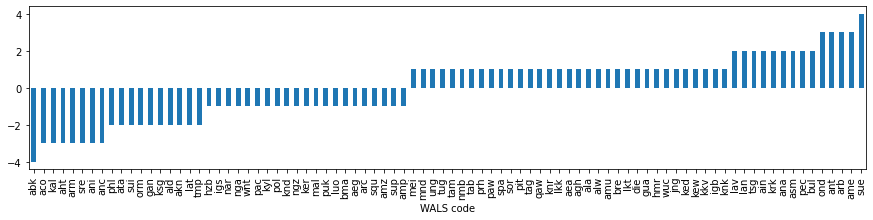

In [16]:
nf = df[diff != 0].assign(diff=diff)

nf['diff'].sort_values().plot.bar(figsize=(15, 3));

In [17]:
pd.DataFrame([pearsonr(nf, 'diff', x) for x in
              ['Estimated Speaker Pop. Size', 'Distance from best fit origin']])

,r,p
diff & Estimated Speaker Pop. Size,0.076365,0.484652
diff & Distance from best fit origin,0.417043,0.000065


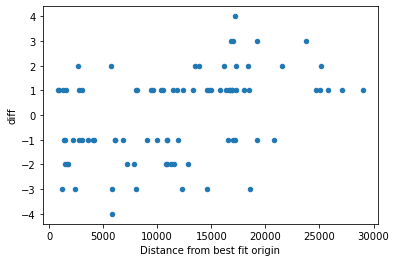

In [18]:
nf.plot.scatter(x='Distance from best fit origin', y='diff');

In [19]:
nf = df[FEAT + S1_OUTC + ['Total Normalized Phoneme Diversity']].copy()

nf[FEAT] = nf[FEAT].apply(scipy.stats.zscore)

nf['Diversity'] = nf[FEAT].mean(axis=1)

pd.DataFrame([pearsonr(nf, 'Diversity', x) for x in
              ['Estimated Speaker Pop. Size', 'Distance from best fit origin']])

,r,p
Diversity & Estimated Speaker Pop. Size,0.066180,1.378965e-01
Diversity & Distance from best fit origin,-0.588842,2.329109e-48


In [20]:
(pearsonr(nf.assign(Population=s1['Estimated Speaker Pop. Size'].apply(np.log10)),
         'Population', 'Diversity')
 .to_frame().T)

,r,p
Population & Diversity,0.413791,2.873599e-22
